In [ ]:
! pip install tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Input, Dense, Embedding, Flatten, Dropout, Activation, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import initializers
from tensorflow.keras.layers import add, concatenate
%matplotlib inline  
import warnings
warnings.filterwarnings('ignore')
from keras.callbacks import EarlyStopping, ModelCheckpoint
from scipy.sparse import csr_matrix
import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from sklearn import preprocessing
from keras.utils import plot_model

In [3]:
def dataPreprocessor(rating_df, num_users, num_items, init_value=0, average=False):
    """
        INPUT: 
            data: pandas DataFrame. columns=['userID', 'itemID', 'rating' ...]
            num_row: int. number of users
            num_col: int. number of items
            
        OUTPUT:
            matrix: 2D numpy array. 
    """
    if average:
      matrix = np.full((num_users, num_items), 0.0)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating
      avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
      inds = np.where(matrix == 0)
      matrix[inds] = np.take(avergae, inds[0])
      
    else:
      matrix = np.full((num_users, num_items), init_value)
      for (_, userID, itemID, rating, timestamp) in rating_df.itertuples():
        matrix[userID, itemID] = rating

    return matrix

In [4]:
def show_error(history, skip):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.plot(np.arange(skip, len(loss), 1), loss[skip:])
    plt.plot(np.arange(skip, len(loss), 1), val_loss[skip:])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     

def show_rmse(history, skip):
    rmse = history.history['masked_rmse_clip']
    val_rmse = history.history['val_masked_rmse_clip']
    plt.plot(np.arange(skip, len(rmse), 1), rmse[skip:])
    plt.plot(np.arange(skip, len(val_rmse), 1), val_rmse[skip:])
    plt.title('model train vs validation masked_rmse')
    plt.ylabel('rmse')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
     
def masked_se(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse
def masked_se_clip_10(y_true, y_pred):
        print(type(y_true),' ',type(y_pred))
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1)
        return masked_mse     

def masked_mse(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
     

def masked_rmse(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

def masked_mse_clip_10(y_true, y_pred):
        # masked function
        y_true = tf.cast(y_true, tf.float32)
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1)
        return masked_mse
def masked_rmse_clip_10(y_true, y_pred):
        # masked function
        mask_true = K.cast(K.not_equal(y_true, 0), K.floatx())
        y_pred = K.clip(y_pred, 1, 10)
        # masked squared error
        masked_squared_error = K.square(mask_true * (y_true - y_pred))
        masked_mse = K.sqrt(K.sum(masked_squared_error, axis=-1) / K.maximum(K.sum(mask_true, axis=-1), 1))
        return masked_mse

## books dataset

In [7]:
datContent = [i.strip().split() for i in open("book_ratings.dat").readlines()][1:]

In [8]:
max_user=0
max_book=0
for r in datContent:
  # print(r)
  max_user=max(max_user,int(r[0]))
  max_book=max(max_book,int(r[1]))
print(max_book,max_user)

17384 2945


## U-AutoRec

In [9]:
def my_proc(cont,init_val):
  matrix = np.full((max_user,max_book),init_val)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  return matrix

def my_proc_avg(cont): 
  matrix = np.full((max_user,max_book),0)
  for r in cont:
    matrix[int(r[0])-1, int(r[1])-1] = float(r[2])
  avergae = np.true_divide(matrix.sum(1), np.maximum((matrix!=0).sum(1), 1))
  inds = np.where(matrix == 0)
  matrix[inds] = np.take(avergae, inds[0])
  return matrix

In [10]:
train_df, test_df = train_test_split(datContent,test_size=0.1,random_state=999613182)  
train_df, validate_df = train_test_split(train_df,test_size=0.1,random_state=999613182) 

In [11]:
print(len(train_df),len(test_df),len(validate_df))

50751 6266 5639


In [12]:
init_v = 0
users_items_matrix_train_zero = my_proc(train_df,init_v)
users_items_matrix_train_avg = my_proc_avg(train_df)
users_items_matrix_validate = my_proc(validate_df,init_v)
users_items_matrix_test = my_proc(test_df,init_v)

In [13]:
users_items_matrix_train_zero.shape

(2945, 17384)

In [14]:
 def Deep_AE_model(X, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode, side_infor_size=0):
    '''
    Build Deep AE for CF
        INPUT: 
            X: #_user X #_item matrix
            layers: List, each element is the number of neuron for a layer
            reg: L2 regularization parameter
            activation: activation function for all dense layer except the last
            last_activation: activation function for the last dense layer
            dropout: dropout rate
            regularizer_encode: regularizer for encoder
            regularizer_decode: regularizer for decoder
            side_infor_size: size of the one hot encoding side information
        OUTPUT:
            Keras model
    '''

    # Input
    input_layer = x = Input(shape=(X.shape[1],), name='UserRating')
    
    # Encoder
    # -----------------------------
    k = int(len(layers)/2)
    i = 0
    for l in layers[:k]:
      x = Dense(l, activation=activation,
                      name='EncLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_encode))(x)
      i = i+1
      
      
    # Latent Space
    # -----------------------------
    x = Dense(layers[k], activation=activation, 
                                name='LatentSpace', kernel_regularizer=regularizers.l2(regularizer_encode))(x)
    
    # Dropout
    x = Dropout(rate = dropout)(x)
    
    # Decoder
    # -----------------------------
    for l in layers[k+1:]:
      i = i-1
      x = Dense(l, activation=activation, 
                      name='DecLayer{}'.format(i), kernel_regularizer=regularizers.l2(regularizer_decode))(x)
      
    # Output

    output_layer = Dense(X.shape[1]-side_infor_size, activation=last_activation, name='UserScorePred', kernel_regularizer=regularizers.l2(regularizer_decode))(x)

    # this model maps an input to its reconstruction
    model = Model(input_layer, output_layer)

    return model
     

In [17]:
# layers = [256, 512, 256]
layers = [512, 256, 128, 256, 512]
#layers = [512, 256, 512]
#layers = [128, 256, 512, 256, 128]
#layers = [512, 512, 512]
dropout = 0.8
# activation = 'sigmoid'
# last_activation = 'linear'
activation = 'selu'
last_activation = 'selu'
regularizer_encode = 0.001
regularizer_decode = 0.001

In [ ]:
Deep_AE = Deep_AE_model(users_items_matrix_train_zero, layers, activation, last_activation, dropout, regularizer_encode, regularizer_decode)
Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse_clip]) 
Deep_AE.summary()

In [ ]:
hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=70,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=2)

In [ ]:
test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
print(test_result)

93/93 [==============================] - 5s 56ms/step - loss: 29.5767 - masked_rmse_clip: 1.5478
[29.5766658782959, 1.5477663278579712]


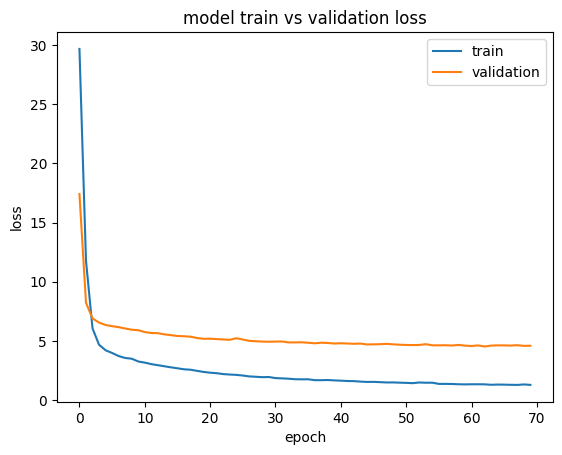

In [ ]:
show_error(hist_Deep_AE,0)

## Activation functions

In [15]:
import gc

In [18]:
losses=[]
val_losses=[]
rmses=[]
val_rmses=[]
activations=['elu','relu','selu','tanh','sigmoid']
outer_act=['linear','sigmoid']
for a in activations:
  for o in outer_act:
    gc.collect()
    Deep_AE = Deep_AE_model(users_items_matrix_train_zero,[128,128,128,128], a, o,0, regularizer_encode, regularizer_decode)
    Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10]) 
    hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                    epochs=70,
                    batch_size=256,
                    validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
    test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
    print("outer: ",a," inner: ",o)
    print(test_result)
    loss = hist_Deep_AE.history['loss']
    val_loss = hist_Deep_AE.history['val_loss']
    rmse = hist_Deep_AE.history['masked_rmse']
    val_rmse = hist_Deep_AE.history['val_masked_rmse']
    losses.append(loss)
    val_losses.append(val_loss)
    rmses.append(rmse)
    val_rmses.append(val_rmse)


Epoch 1/70
12/12 [==============================] - 8s 532ms/step - loss: 28.9129 - masked_rmse: 3.5012 - masked_rmse_clip_10: 3.1111 - val_loss: 23.0280 - val_masked_rmse: 2.9931 - val_masked_rmse_clip_10: 2.8203
Epoch 2/70
12/12 [==============================] - 7s 530ms/step - loss: 15.3417 - masked_rmse: 2.4036 - masked_rmse_clip_10: 2.2196 - val_loss: 10.2495 - val_masked_rmse: 1.6932 - val_masked_rmse_clip_10: 1.3646
Epoch 3/70
12/12 [==============================] - 6s 515ms/step - loss: 6.2546 - masked_rmse: 1.4240 - masked_rmse_clip_10: 1.3015 - val_loss: 6.5474 - val_masked_rmse: 1.3861 - val_masked_rmse_clip_10: 1.2972
Epoch 4/70
12/12 [==============================] - 6s 555ms/step - loss: 3.0735 - masked_rmse: 0.9622 - masked_rmse_clip_10: 0.8943 - val_loss: 5.1678 - val_masked_rmse: 1.1507 - val_masked_rmse_clip_10: 1.0816
Epoch 5/70
12/12 [==============================] - 6s 516ms/step - loss: 2.0922 - masked_rmse: 0.7231 - masked_rmse_clip_10: 0.7130 - val_loss: 4.7

Epoch 1/70
12/12 [==============================] - 10s 811ms/step - loss: 26.0775 - masked_rmse: 3.3232 - masked_rmse_clip_10: 3.1125 - val_loss: 23.8775 - val_masked_rmse: 3.0634 - val_masked_rmse_clip_10: 2.8866
Epoch 2/70
12/12 [==============================] - 7s 563ms/step - loss: 24.2218 - masked_rmse: 3.2109 - masked_rmse_clip_10: 3.1125 - val_loss: 21.6995 - val_masked_rmse: 2.9113 - val_masked_rmse_clip_10: 2.8866
Epoch 3/70
12/12 [==============================] - 9s 765ms/step - loss: 22.8946 - masked_rmse: 3.1144 - masked_rmse_clip_10: 3.1125 - val_loss: 21.6357 - val_masked_rmse: 2.9040 - val_masked_rmse_clip_10: 2.8866
Epoch 4/70
12/12 [==============================] - 6s 515ms/step - loss: 22.8584 - masked_rmse: 3.1125 - masked_rmse_clip_10: 3.1125 - val_loss: 21.5852 - val_masked_rmse: 2.9043 - val_masked_rmse_clip_10: 2.8866
Epoch 5/70
12/12 [==============================] - 7s 623ms/step - loss: 22.7896 - masked_rmse: 3.1125 - masked_rmse_clip_10: 3.1125 - val_los

Epoch 1/70
12/12 [==============================] - 9s 687ms/step - loss: 28.1420 - masked_rmse: 3.4524 - masked_rmse_clip_10: 3.0950 - val_loss: 18.6467 - val_masked_rmse: 2.6576 - val_masked_rmse_clip_10: 2.5461
Epoch 2/70
12/12 [==============================] - 6s 492ms/step - loss: 16.9123 - masked_rmse: 2.3034 - masked_rmse_clip_10: 1.9673 - val_loss: 12.3187 - val_masked_rmse: 2.0738 - val_masked_rmse_clip_10: 1.9762
Epoch 3/70
12/12 [==============================] - 7s 599ms/step - loss: 10.7043 - masked_rmse: 2.0336 - masked_rmse_clip_10: 1.9806 - val_loss: 10.1651 - val_masked_rmse: 1.7752 - val_masked_rmse_clip_10: 1.4128
Epoch 4/70
12/12 [==============================] - 5s 394ms/step - loss: 6.7508 - masked_rmse: 1.5453 - masked_rmse_clip_10: 1.2760 - val_loss: 7.9325 - val_masked_rmse: 1.6031 - val_masked_rmse_clip_10: 1.5366
Epoch 5/70
12/12 [==============================] - 6s 522ms/step - loss: 4.1220 - masked_rmse: 1.1750 - masked_rmse_clip_10: 1.0729 - val_loss: 5

Epoch 1/70
12/12 [==============================] - 8s 567ms/step - loss: 25.9742 - masked_rmse: 3.3185 - masked_rmse_clip_10: 3.1125 - val_loss: 23.2875 - val_masked_rmse: 3.0268 - val_masked_rmse_clip_10: 2.8866
Epoch 2/70
12/12 [==============================] - 6s 504ms/step - loss: 23.5623 - masked_rmse: 3.1686 - masked_rmse_clip_10: 3.1125 - val_loss: 21.5768 - val_masked_rmse: 2.9059 - val_masked_rmse_clip_10: 2.8866
Epoch 3/70
12/12 [==============================] - 6s 510ms/step - loss: 22.8097 - masked_rmse: 3.1127 - masked_rmse_clip_10: 3.1125 - val_loss: 21.5681 - val_masked_rmse: 2.9045 - val_masked_rmse_clip_10: 2.8866
Epoch 4/70
12/12 [==============================] - 5s 437ms/step - loss: 22.7812 - masked_rmse: 3.1125 - masked_rmse_clip_10: 3.1125 - val_loss: 21.5118 - val_masked_rmse: 2.9043 - val_masked_rmse_clip_10: 2.8866
Epoch 5/70
12/12 [==============================] - 6s 501ms/step - loss: 22.7234 - masked_rmse: 3.1125 - masked_rmse_clip_10: 3.1125 - val_loss

Epoch 1/70
12/12 [==============================] - 7s 480ms/step - loss: 28.8104 - masked_rmse: 3.4939 - masked_rmse_clip_10: 3.1113 - val_loss: 23.6745 - val_masked_rmse: 3.0352 - val_masked_rmse_clip_10: 2.8469
Epoch 2/70
12/12 [==============================] - 5s 467ms/step - loss: 15.3421 - masked_rmse: 2.4444 - masked_rmse_clip_10: 2.3476 - val_loss: 9.7918 - val_masked_rmse: 1.7203 - val_masked_rmse_clip_10: 1.2631
Epoch 3/70
12/12 [==============================] - 5s 425ms/step - loss: 4.9044 - masked_rmse: 1.2470 - masked_rmse_clip_10: 1.0748 - val_loss: 6.0589 - val_masked_rmse: 1.3236 - val_masked_rmse_clip_10: 1.2676
Epoch 4/70
12/12 [==============================] - 6s 496ms/step - loss: 2.7490 - masked_rmse: 0.8975 - masked_rmse_clip_10: 0.8779 - val_loss: 5.1206 - val_masked_rmse: 1.1300 - val_masked_rmse_clip_10: 1.0334
Epoch 5/70
12/12 [==============================] - 7s 605ms/step - loss: 1.9937 - masked_rmse: 0.6947 - masked_rmse_clip_10: 0.6764 - val_loss: 4.70

Epoch 1/70
12/12 [==============================] - 8s 577ms/step - loss: 25.9493 - masked_rmse: 3.3123 - masked_rmse_clip_10: 3.1125 - val_loss: 23.2970 - val_masked_rmse: 3.0180 - val_masked_rmse_clip_10: 2.8866
Epoch 2/70
12/12 [==============================] - 6s 515ms/step - loss: 23.6499 - masked_rmse: 3.1646 - masked_rmse_clip_10: 3.1125 - val_loss: 21.7314 - val_masked_rmse: 2.9073 - val_masked_rmse_clip_10: 2.8866
Epoch 3/70
12/12 [==============================] - 9s 756ms/step - loss: 22.9452 - masked_rmse: 3.1133 - masked_rmse_clip_10: 3.1125 - val_loss: 21.6778 - val_masked_rmse: 2.9039 - val_masked_rmse_clip_10: 2.8866
Epoch 4/70
12/12 [==============================] - 6s 517ms/step - loss: 22.8955 - masked_rmse: 3.1125 - masked_rmse_clip_10: 3.1125 - val_loss: 21.6170 - val_masked_rmse: 2.9042 - val_masked_rmse_clip_10: 2.8866
Epoch 5/70
12/12 [==============================] - 7s 610ms/step - loss: 22.8235 - masked_rmse: 3.1125 - masked_rmse_clip_10: 3.1125 - val_loss

Epoch 1/70
12/12 [==============================] - 7s 488ms/step - loss: 29.2871 - masked_rmse: 3.5258 - masked_rmse_clip_10: 3.1125 - val_loss: 26.3824 - val_masked_rmse: 3.2189 - val_masked_rmse_clip_10: 2.8866
Epoch 2/70
12/12 [==============================] - 6s 483ms/step - loss: 25.9925 - masked_rmse: 3.3204 - masked_rmse_clip_10: 3.0991 - val_loss: 21.9674 - val_masked_rmse: 2.9184 - val_masked_rmse_clip_10: 2.8117
Epoch 3/70
12/12 [==============================] - 5s 403ms/step - loss: 20.6439 - masked_rmse: 2.9367 - masked_rmse_clip_10: 2.8974 - val_loss: 17.7905 - val_masked_rmse: 2.5918 - val_masked_rmse_clip_10: 2.5429
Epoch 4/70
12/12 [==============================] - 6s 542ms/step - loss: 16.0420 - masked_rmse: 2.5560 - masked_rmse_clip_10: 2.5527 - val_loss: 14.6499 - val_masked_rmse: 2.3021 - val_masked_rmse_clip_10: 2.2596
Epoch 5/70
12/12 [==============================] - 6s 496ms/step - loss: 12.7252 - masked_rmse: 2.2309 - masked_rmse_clip_10: 2.2307 - val_loss

Epoch 1/70
12/12 [==============================] - 8s 529ms/step - loss: 26.0987 - masked_rmse: 3.3249 - masked_rmse_clip_10: 3.1125 - val_loss: 24.1013 - val_masked_rmse: 3.0790 - val_masked_rmse_clip_10: 2.8866
Epoch 2/70
12/12 [==============================] - 6s 516ms/step - loss: 25.3338 - masked_rmse: 3.2889 - masked_rmse_clip_10: 3.1125 - val_loss: 23.1881 - val_masked_rmse: 3.0201 - val_masked_rmse_clip_10: 2.8866
Epoch 3/70
12/12 [==============================] - 5s 459ms/step - loss: 24.3186 - masked_rmse: 3.2189 - masked_rmse_clip_10: 3.1125 - val_loss: 22.5617 - val_masked_rmse: 2.9725 - val_masked_rmse_clip_10: 2.8866
Epoch 4/70
12/12 [==============================] - 5s 409ms/step - loss: 23.7571 - masked_rmse: 3.1748 - masked_rmse_clip_10: 3.1125 - val_loss: 22.3276 - val_masked_rmse: 2.9503 - val_masked_rmse_clip_10: 2.8866
Epoch 5/70
12/12 [==============================] - 7s 627ms/step - loss: 23.5529 - masked_rmse: 3.1553 - masked_rmse_clip_10: 3.1125 - val_loss

Epoch 1/70
12/12 [==============================] - 8s 570ms/step - loss: 28.1582 - masked_rmse: 3.4566 - masked_rmse_clip_10: 3.1125 - val_loss: 24.1732 - val_masked_rmse: 3.0780 - val_masked_rmse_clip_10: 2.8853
Epoch 2/70
12/12 [==============================] - 5s 442ms/step - loss: 23.1800 - masked_rmse: 3.1302 - masked_rmse_clip_10: 3.0368 - val_loss: 19.5831 - val_masked_rmse: 2.7429 - val_masked_rmse_clip_10: 2.6810
Epoch 3/70
12/12 [==============================] - 5s 401ms/step - loss: 17.8535 - masked_rmse: 2.7174 - masked_rmse_clip_10: 2.7078 - val_loss: 15.7836 - val_masked_rmse: 2.4152 - val_masked_rmse_clip_10: 2.3726
Epoch 4/70
12/12 [==============================] - 7s 601ms/step - loss: 13.8947 - masked_rmse: 2.3538 - masked_rmse_clip_10: 2.3536 - val_loss: 13.2404 - val_masked_rmse: 2.1531 - val_masked_rmse_clip_10: 2.1096
Epoch 5/70
12/12 [==============================] - 6s 487ms/step - loss: 11.1987 - masked_rmse: 2.0606 - masked_rmse_clip_10: 2.0605 - val_loss

Epoch 1/70
12/12 [==============================] - 8s 609ms/step - loss: 25.8459 - masked_rmse: 3.3084 - masked_rmse_clip_10: 3.1125 - val_loss: 23.5934 - val_masked_rmse: 3.0441 - val_masked_rmse_clip_10: 2.8866
Epoch 2/70
12/12 [==============================] - 5s 401ms/step - loss: 24.7314 - masked_rmse: 3.2455 - masked_rmse_clip_10: 3.1125 - val_loss: 22.8059 - val_masked_rmse: 2.9887 - val_masked_rmse_clip_10: 2.8866
Epoch 3/70
12/12 [==============================] - 7s 577ms/step - loss: 23.9603 - masked_rmse: 3.1879 - masked_rmse_clip_10: 3.1125 - val_loss: 22.4502 - val_masked_rmse: 2.9574 - val_masked_rmse_clip_10: 2.8866
Epoch 4/70
12/12 [==============================] - 6s 506ms/step - loss: 23.6683 - masked_rmse: 3.1614 - masked_rmse_clip_10: 3.1125 - val_loss: 22.3419 - val_masked_rmse: 2.9447 - val_masked_rmse_clip_10: 2.8866
Epoch 5/70
12/12 [==============================] - 6s 531ms/step - loss: 23.5634 - masked_rmse: 3.1506 - masked_rmse_clip_10: 3.1125 - val_loss

In [21]:
import json
books_activation_results={'loss':losses,'val_loss':val_losses,'rmse':rmses,'val_rmse':val_rmses}
json.dump(books_activation_results,open('books_activation.json','w'))

In [ ]:
books_activation_results

In [22]:
losses=[]
val_losses=[]
rmses=[]
val_rmses=[]
activations=['elu','relu','selu','tanh','sigmoid']

for a in activations:
  gc.collect()
  Deep_AE = Deep_AE_model(users_items_matrix_train_zero,[128,128,128,128], a,'selu',0, regularizer_encode, regularizer_decode)
  Deep_AE.compile(optimizer = Adam(lr=0.0001), loss=masked_mse, metrics=[masked_rmse,masked_rmse_clip_10]) 
  hist_Deep_AE = Deep_AE.fit(x=users_items_matrix_train_zero, y=users_items_matrix_train_zero,
                  epochs=70,
                  batch_size=256,
                  validation_data=[users_items_matrix_train_zero, users_items_matrix_validate], verbose=1)
  test_result = Deep_AE.evaluate(users_items_matrix_train_avg, users_items_matrix_test)
  print("outer: ",a," inner: selu")
  print(test_result)
  loss = hist_Deep_AE.history['loss']
  val_loss = hist_Deep_AE.history['val_loss']
  rmse = hist_Deep_AE.history['masked_rmse']
  val_rmse = hist_Deep_AE.history['val_masked_rmse']
  losses.append(loss)
  val_losses.append(val_loss)
  rmses.append(rmse)
  val_rmses.append(val_rmse)

Epoch 1/70
12/12 [==============================] - 10s 741ms/step - loss: 29.0603 - masked_rmse: 3.5106 - masked_rmse_clip_10: 3.1114 - val_loss: 23.6895 - val_masked_rmse: 3.0383 - val_masked_rmse_clip_10: 2.8359
Epoch 2/70
12/12 [==============================] - 6s 522ms/step - loss: 17.1349 - masked_rmse: 2.4878 - masked_rmse_clip_10: 2.2437 - val_loss: 9.9137 - val_masked_rmse: 1.7184 - val_masked_rmse_clip_10: 1.4817
Epoch 3/70
12/12 [==============================] - 6s 483ms/step - loss: 6.3685 - masked_rmse: 1.4674 - masked_rmse_clip_10: 1.3640 - val_loss: 6.8173 - val_masked_rmse: 1.4160 - val_masked_rmse_clip_10: 1.3051
Epoch 4/70
12/12 [==============================] - 6s 500ms/step - loss: 3.3070 - masked_rmse: 1.0109 - masked_rmse_clip_10: 0.9323 - val_loss: 5.3550 - val_masked_rmse: 1.1839 - val_masked_rmse_clip_10: 1.1104
Epoch 5/70
12/12 [==============================] - 6s 507ms/step - loss: 2.1937 - masked_rmse: 0.7513 - masked_rmse_clip_10: 0.7368 - val_loss: 4.7

Epoch 1/70
12/12 [==============================] - 9s 706ms/step - loss: 28.9580 - masked_rmse: 3.5077 - masked_rmse_clip_10: 3.1107 - val_loss: 23.0522 - val_masked_rmse: 3.0011 - val_masked_rmse_clip_10: 2.8142
Epoch 2/70
12/12 [==============================] - 6s 499ms/step - loss: 17.1924 - masked_rmse: 2.5175 - masked_rmse_clip_10: 2.2508 - val_loss: 12.4131 - val_masked_rmse: 1.9433 - val_masked_rmse_clip_10: 1.6754
Epoch 3/70
12/12 [==============================] - 6s 531ms/step - loss: 10.3544 - masked_rmse: 1.9233 - masked_rmse_clip_10: 1.7919 - val_loss: 9.1311 - val_masked_rmse: 1.7013 - val_masked_rmse_clip_10: 1.5232
Epoch 4/70
12/12 [==============================] - 5s 422ms/step - loss: 5.7133 - masked_rmse: 1.4138 - masked_rmse_clip_10: 1.2091 - val_loss: 7.0520 - val_masked_rmse: 1.4836 - val_masked_rmse_clip_10: 1.4052
Epoch 5/70
12/12 [==============================] - 6s 541ms/step - loss: 3.4141 - masked_rmse: 1.0529 - masked_rmse_clip_10: 0.9702 - val_loss: 5.

Epoch 1/70
12/12 [==============================] - 8s 591ms/step - loss: 29.2387 - masked_rmse: 3.5210 - masked_rmse_clip_10: 3.1125 - val_loss: 25.6229 - val_masked_rmse: 3.1658 - val_masked_rmse_clip_10: 2.8842
Epoch 2/70
12/12 [==============================] - 7s 612ms/step - loss: 19.3150 - masked_rmse: 2.7978 - masked_rmse_clip_10: 2.7000 - val_loss: 8.8693 - val_masked_rmse: 1.6743 - val_masked_rmse_clip_10: 1.4930
Epoch 3/70
12/12 [==============================] - 5s 423ms/step - loss: 5.7493 - masked_rmse: 1.3710 - masked_rmse_clip_10: 1.1639 - val_loss: 5.9274 - val_masked_rmse: 1.3008 - val_masked_rmse_clip_10: 1.2423
Epoch 4/70
12/12 [==============================] - 7s 615ms/step - loss: 2.8029 - masked_rmse: 0.9115 - masked_rmse_clip_10: 0.8959 - val_loss: 5.0066 - val_masked_rmse: 1.1150 - val_masked_rmse_clip_10: 1.0231
Epoch 5/70
12/12 [==============================] - 6s 499ms/step - loss: 1.9991 - masked_rmse: 0.6935 - masked_rmse_clip_10: 0.6737 - val_loss: 4.62

Epoch 1/70
12/12 [==============================] - 8s 609ms/step - loss: 29.4063 - masked_rmse: 3.5327 - masked_rmse_clip_10: 3.1125 - val_loss: 26.6702 - val_masked_rmse: 3.2363 - val_masked_rmse_clip_10: 2.8866
Epoch 2/70
12/12 [==============================] - 5s 408ms/step - loss: 26.3194 - masked_rmse: 3.3409 - masked_rmse_clip_10: 3.1008 - val_loss: 22.1689 - val_masked_rmse: 2.9318 - val_masked_rmse_clip_10: 2.8168
Epoch 3/70
12/12 [==============================] - 5s 442ms/step - loss: 20.7367 - masked_rmse: 2.9431 - masked_rmse_clip_10: 2.8981 - val_loss: 17.6857 - val_masked_rmse: 2.5819 - val_masked_rmse_clip_10: 2.5325
Epoch 4/70
12/12 [==============================] - 6s 512ms/step - loss: 15.8974 - masked_rmse: 2.5413 - masked_rmse_clip_10: 2.5373 - val_loss: 14.3989 - val_masked_rmse: 2.2769 - val_masked_rmse_clip_10: 2.2346
Epoch 5/70
12/12 [==============================] - 5s 433ms/step - loss: 12.4330 - masked_rmse: 2.2011 - masked_rmse_clip_10: 2.2009 - val_loss

Epoch 1/70
12/12 [==============================] - 9s 697ms/step - loss: 28.3179 - masked_rmse: 3.4665 - masked_rmse_clip_10: 3.1125 - val_loss: 24.4080 - val_masked_rmse: 3.0942 - val_masked_rmse_clip_10: 2.8862
Epoch 2/70
12/12 [==============================] - 6s 495ms/step - loss: 23.4667 - masked_rmse: 3.1514 - masked_rmse_clip_10: 3.0481 - val_loss: 19.7659 - val_masked_rmse: 2.7582 - val_masked_rmse_clip_10: 2.6943
Epoch 3/70
12/12 [==============================] - 6s 527ms/step - loss: 17.7885 - masked_rmse: 2.7123 - masked_rmse_clip_10: 2.7021 - val_loss: 15.5602 - val_masked_rmse: 2.3970 - val_masked_rmse_clip_10: 2.3535
Epoch 4/70
12/12 [==============================] - 6s 497ms/step - loss: 13.4727 - masked_rmse: 2.3152 - masked_rmse_clip_10: 2.3149 - val_loss: 12.8273 - val_masked_rmse: 2.1122 - val_masked_rmse_clip_10: 2.0679
Epoch 5/70
12/12 [==============================] - 6s 522ms/step - loss: 10.6706 - masked_rmse: 2.0031 - masked_rmse_clip_10: 2.0029 - val_loss

In [4]:
import json
data = json.load(open('books_activation.json','r'))

In [6]:
rmses

NameError: ignored

In [5]:
data.keys()

dict_keys(['loss', 'val_loss', 'rmse', 'val_rmse'])